In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clean-test-data/error_file_4.txt
/kaggle/input/clean-test-data/error_details_20.txt
/kaggle/input/clean-test-data/error_file_10.txt
/kaggle/input/clean-test-data/error_details_7.txt
/kaggle/input/clean-test-data/error_details_11.txt
/kaggle/input/clean-test-data/error_details_9.txt
/kaggle/input/clean-test-data/error_details_3.txt
/kaggle/input/clean-test-data/error_details_19.txt
/kaggle/input/clean-test-data/error_details_1.txt
/kaggle/input/clean-test-data/clean_data.txt
/kaggle/input/clean-test-data/error_details_4.txt
/kaggle/input/clean-test-data/error_file_3.txt
/kaggle/input/clean-test-data/error_file_6.txt
/kaggle/input/clean-test-data/error_file_8.txt
/kaggle/input/clean-test-data/error_file_2.txt
/kaggle/input/clean-test-data/error_details_16.txt
/kaggle/input/clean-test-data/error_file_1.txt
/kaggle/input/clean-test-data/error_file_17.txt
/kaggle/input/clean-test-data/error_file_19.txt
/kaggle/input/clean-test-data/error_file_18.txt
/kaggle/input/clean-test-da

In [2]:
pip install transformers datasets matplotlib evaluate seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=0a828377652a4e84d6c1e5e2420b2283bb5c4d4746e68371d403bdb67bac5ee7
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from transformers import ProgressCallback
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict


def read_conll(filename):
    sentences = []
    labels = []
    with open(filename, "r", encoding="utf-8") as f:
        words = []
        tags = []
        for line in f:
            line = line.strip()
            if not line:
                if words:
                    sentences.append(words)
                    labels.append(tags)
                    words, tags = [], []
            else:
                splits = line.split()
                if len(splits) != 2:
                    continue  # skip badly formatted lines
                word, tag = splits
                words.append(word)
                tags.append(tag)
        if words:
            sentences.append(words)
            labels.append(tags)
    return list(zip(sentences, labels))

raw_data = read_conll("/kaggle/input/clean-test-data/clean_error_data.txt")
raw_data = raw_data[:35000]
print(len(raw_data))


train_data, val_data = train_test_split(raw_data, test_size=0.1, random_state=42)

train_dataset = Dataset.from_dict({
    "tokens": [x[0] for x in train_data],
    "labels": [x[1] for x in train_data]
})

val_dataset = Dataset.from_dict({
    "tokens": [x[0] for x in val_data],
    "labels": [x[1] for x in val_data]
})

datasets = DatasetDict({"train": train_dataset, "validation": val_dataset})

label_list = ["O", "B-ERR"]
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(example["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id.get(label[word_idx], 0))
            else:
                label_ids.append(label_to_id.get(label[word_idx], 0))
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

35000


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/31500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

In [4]:

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
data_collator = DataCollatorForTokenClassification(tokenizer)


epoch_metrics = {"precision": [], "recall": [], "f1": [], "accuracy": []}

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [
        [label_list[l] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]
    true_predictions = [
        [label_list[p] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]

    all_preds = sum(true_predictions, [])
    all_labels = sum(true_labels, [])

    results = {
        "precision": precision_score(all_labels, all_preds, average="macro", zero_division=0),
        "recall": recall_score(all_labels, all_preds, average="macro", zero_division=0),
        "f1": f1_score(all_labels, all_preds, average="macro", zero_division=0),
        "accuracy": accuracy_score(all_labels, all_preds),
    }

    for k in epoch_metrics:
        epoch_metrics[k].append(results[k])

    print("\nMetrics:", results)
    return results

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-257aa3242180>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/7876 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.259100,0.180675,0.929754,0.929652,0.929674,0.929681
2,0.170600,0.162784,0.937353,0.937286,0.937303,0.937308
3,0.133400,0.158111,0.943619,0.943430,0.943462,0.943471
4,0.110700,0.162044,0.944499,0.944120,0.944166,0.944182


{'loss': 0.2591, 'grad_norm': 7.629538059234619, 'learning_rate': 1.5000000000000002e-05, 'epoch': 1.0}


  0%|          | 0/219 [00:00<?, ?it/s]


Metrics: {'precision': 0.9297536305186311, 'recall': 0.9296523269907326, 'f1': 0.9296736943911547, 'accuracy': 0.9296814502869387}
{'eval_loss': 0.1806747019290924, 'eval_precision': 0.9297536305186311, 'eval_recall': 0.9296523269907326, 'eval_f1': 0.9296736943911547, 'eval_accuracy': 0.9296814502869387, 'eval_runtime': 31.5274, 'eval_samples_per_second': 111.015, 'eval_steps_per_second': 6.946, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1706, 'grad_norm': 4.403078556060791, 'learning_rate': 1e-05, 'epoch': 2.0}


  0%|          | 0/219 [00:00<?, ?it/s]


Metrics: {'precision': 0.9373527747817225, 'recall': 0.9372864603012079, 'f1': 0.9373032408442502, 'accuracy': 0.9373083981287988}
{'eval_loss': 0.162784144282341, 'eval_precision': 0.9373527747817225, 'eval_recall': 0.9372864603012079, 'eval_f1': 0.9373032408442502, 'eval_accuracy': 0.9373083981287988, 'eval_runtime': 31.3407, 'eval_samples_per_second': 111.676, 'eval_steps_per_second': 6.988, 'epoch': 2.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1334, 'grad_norm': 5.304576873779297, 'learning_rate': 5e-06, 'epoch': 3.0}


  0%|          | 0/219 [00:00<?, ?it/s]


Metrics: {'precision': 0.9436191046189326, 'recall': 0.9434302377236214, 'f1': 0.9434618562705852, 'accuracy': 0.9434714811553925}
{'eval_loss': 0.1581108719110489, 'eval_precision': 0.9436191046189326, 'eval_recall': 0.9434302377236214, 'eval_f1': 0.9434618562705852, 'eval_accuracy': 0.9434714811553925, 'eval_runtime': 31.3088, 'eval_samples_per_second': 111.789, 'eval_steps_per_second': 6.995, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'loss': 0.1107, 'grad_norm': 6.510141372680664, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/219 [00:00<?, ?it/s]


Metrics: {'precision': 0.9444989161305657, 'recall': 0.9441204812131823, 'f1': 0.9441656079052071, 'accuracy': 0.9441821981309204}
{'eval_loss': 0.16204433143138885, 'eval_precision': 0.9444989161305657, 'eval_recall': 0.9441204812131823, 'eval_f1': 0.9441656079052071, 'eval_accuracy': 0.9441821981309204, 'eval_runtime': 31.3597, 'eval_samples_per_second': 111.608, 'eval_steps_per_second': 6.983, 'epoch': 4.0}
{'train_runtime': 3392.1675, 'train_samples_per_second': 37.144, 'train_steps_per_second': 2.322, 'train_loss': 0.16844324680558917, 'epoch': 4.0}


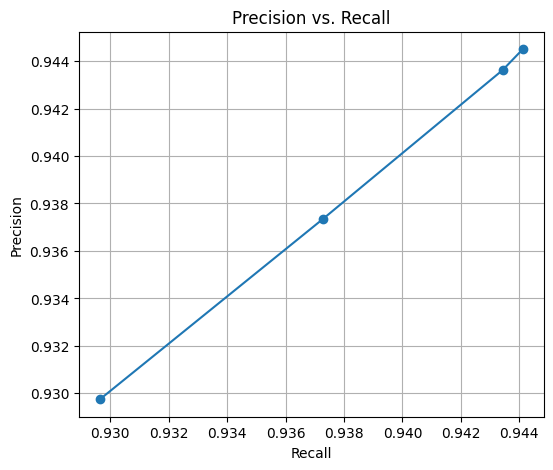

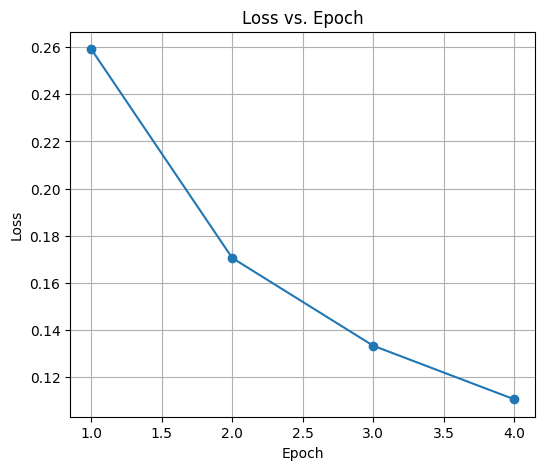

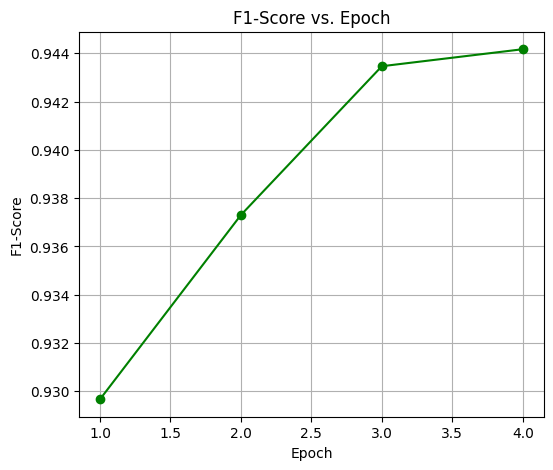

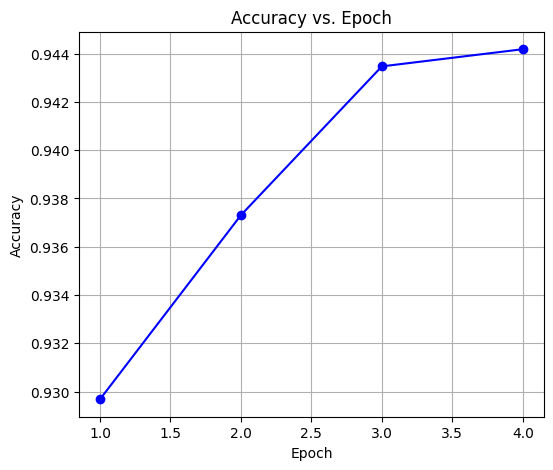

In [5]:

args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    load_best_model_at_end=False,
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.add_callback(ProgressCallback())
trainer.train()


epochs = list(range(1, len(epoch_metrics["accuracy"]) + 1))

# Precision vs Recall
plt.figure(figsize=(6, 5))
plt.plot(epoch_metrics["recall"], epoch_metrics["precision"], marker='o')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs. Recall")
plt.grid(True)
plt.show()

# Loss vs. Epoch (collected from trainer logs)
training_logs = trainer.state.log_history
losses = [log["loss"] for log in training_logs if "loss" in log]
loss_epochs = list(range(1, len(losses) + 1))

plt.figure(figsize=(6, 5))
plt.plot(loss_epochs, losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.grid(True)
plt.show()

# F1-Score vs Epoch
plt.figure(figsize=(6, 5))
plt.plot(epochs, epoch_metrics["f1"], marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.title("F1-Score vs. Epoch")
plt.grid(True)
plt.show()

# Accuracy vs Epoch
plt.figure(figsize=(6, 5))
plt.plot(epochs, epoch_metrics["accuracy"], marker='o', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.grid(True)
plt.show()



In [6]:

model.save_pretrained("./results")
tokenizer.save_pretrained("./results")

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/sentencepiece.bpe.model',
 './results/added_tokens.json',
 './results/tokenizer.json')

In [17]:

inference_tokenizer = AutoTokenizer.from_pretrained("./results")
inference_model = AutoModelForTokenClassification.from_pretrained("./results")
inference_model.eval()

id_to_label = {0: "O", 1: "B-ERR"}

tamil_sentence = "அவள் புத்தகம் படித்தள்"
words = tamil_sentence.strip().split()

encoding = inference_tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True)
with torch.no_grad():
    outputs = inference_model(**encoding)
    predictions = torch.argmax(outputs.logits, dim=2)

word_ids = encoding.word_ids()
pred_labels = [id_to_label[pred.item()] for pred in predictions[0]]

final_output = {}
for idx, word_idx in enumerate(word_ids):
    if word_idx is None:
        continue
    word = words[word_idx]
    if word not in final_output:
        final_output[word] = pred_labels[idx]

print("Inference Results:")
for word, label in final_output.items():
    status = "OK" if label == "O" else "ERROR"
    print(f"{word:<20} → {label:<6}  {status}")


Inference Results:
அவள்                 → O       OK
புத்தகம்             → O       OK
படித்தள்             → B-ERR   ERROR
